In [28]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
import scipy

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.settings.figdir = 'figures'  # Directory to save figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6)) 

## Step 1: Initialize data

In [11]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'c_elegans' / 'c_elegans_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [12]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_train_autoencoder_c_elegans_whole_genome/bd5c1915-ea4d-4428-9aeb-99d3346bcc55/checkpoints/epoch_19.ckpt"

In [13]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=17747, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=100, bias=True)
    )
  )
  (x_from_x0): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=100, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_runn

## Initialize FM model

In [14]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001
                        }

In [15]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_fm_resnet_autoencoder_c_elegans_whole_genome/c53fbf45-1ba2-466f-ac8b-224d5fef89e6/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [16]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-0.3549,  0.8345,  0.0168,  ..., -0.9087,  0.0922,  0.7461],
        [ 0.1491, -1.1411, -0.2781,  ..., -2.0568, -0.6414,  1.2975],
        [ 0.4939,  1.2045,  0.4013,  ...,  1.2036, -0.8624, -0.2181],
        ...,
        [-1.1928,  0.6475,  0.3693,  ..., -2.2278,  0.6591, -0.0135],
        [ 0.2234,  0.5528, -0.1927,  ...,  0.3662,  1.5047, -0.0536],
        [ 0.5007,  1.3417,  0.2402,  ..., -0.3699,  0.1425,  1.6496]],
       device='cuda:0', requires_grad=True)


Initializations

In [17]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=100,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

# generative_model.denoising_model.embed_size_factor = True
generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=17747, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
       

**Check the data**

In [18]:
adata_original = sc.read_h5ad(data_path)
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

In [19]:
adata_original

AnnData object with n_obs × n_vars = 71760 × 17747
    obs: 'cell', 'numi', 'time_point', 'batch', 'size_factor', 'cell_type', 'cell_subtype', 'plot_cell_type', 'raw_embryo_time', 'embryo_time', 'embryo_time_bin', 'raw_embryo_time_bin', 'lineage', 'passed_qc'
    var: 'gene_id', 'gene_name', 'gene_description', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

In [20]:
unique_classes = np.unique(adata_original.obs.cell_type, return_counts=True)
class_freq_dict = dict(zip(unique_classes[0], unique_classes[1]))
norm_const = np.sum(1/unique_classes[1])
class_prop_dict = dict(zip(unique_classes[0], (1/unique_classes[1])/norm_const))
class_prop = (1/unique_classes[1])/norm_const
class_idx = dict(zip(range(len(unique_classes[0])), unique_classes[0]))

In [21]:
class_freq_dict

{'ABarpaaa_lineage': 221,
 'Arcade_cell': 344,
 'Body_wall_muscle': 13957,
 'Ciliated_amphid_neuron': 4856,
 'Ciliated_non_amphid_neuron': 3552,
 'Coelomocyte': 626,
 'Excretory_cell': 173,
 'Excretory_cell_parent': 49,
 'Excretory_duct_and_pore': 76,
 'Excretory_gland': 157,
 'G2_and_W_blasts': 60,
 'GLR': 638,
 'Germline': 408,
 'Glia': 1488,
 'Hypodermis': 6179,
 'Intestinal_and_rectal_muscle': 458,
 'Intestine': 1385,
 'M_cell': 241,
 'Parent_of_exc_duct_pore_DB_1_3': 51,
 'Parent_of_exc_gland_AVK': 95,
 'Parent_of_hyp1V_and_ant_arc_V': 63,
 'Pharyngeal_gland': 623,
 'Pharyngeal_intestinal_valve': 394,
 'Pharyngeal_marginal_cell': 735,
 'Pharyngeal_muscle': 2052,
 'Pharyngeal_neuron': 1179,
 'Rectal_cell': 257,
 'Rectal_gland': 222,
 'Seam_cell': 2204,
 'T': 120,
 'XXX': 22,
 'Z1_Z4': 295,
 'hmc': 153,
 'hmc_and_homolog': 103,
 'hmc_homolog': 124,
 'hyp1V_and_ant_arc_V': 89,
 'nan': 28111}

In [23]:
class_prop_dict

{'ABarpaaa_lineage': 0.01898563523739366,
 'Arcade_cell': 0.012197166824023253,
 'Body_wall_muscle': 0.0003006251621024575,
 'Ciliated_amphid_neuron': 0.000864049709115321,
 'Ciliated_non_amphid_neuron': 0.0011812571473716212,
 'Coelomocyte': 0.006702596465597442,
 'Excretory_cell': 0.024253325939098257,
 'Excretory_cell_parent': 0.0856290895400816,
 'Excretory_duct_and_pore': 0.055208228782421036,
 'Excretory_gland': 0.026725002467923562,
 'G2_and_W_blasts': 0.06993042312439998,
 'GLR': 0.006576528820476487,
 'Germline': 0.010283885753588233,
 'Glia': 0.0028197751259838705,
 'Hypodermis': 0.0006790460248363811,
 'Intestinal_and_rectal_muscle': 0.009161190802323142,
 'Intestine': 0.0030294768140534285,
 'M_cell': 0.017410063848398334,
 'Parent_of_exc_duct_pore_DB_1_3': 0.08227108602870586,
 'Parent_of_exc_gland_AVK': 0.04416658302593683,
 'Parent_of_hyp1V_and_ant_arc_V': 0.06660040297561902,
 'Pharyngeal_gland': 0.006734872211017655,
 'Pharyngeal_intestinal_valve': 0.010649303013868017

## General conditional

In [29]:
np.random.seed(42)
samples = np.random.choice(range(len(class_idx)), size=130000, replace=True, p=scipy.special.softmax(class_prop))

In [37]:
condition_names = [class_idx[sample] for sample in samples]
condition_val = torch.tensor([dataset.id2cov["cell_type"][condition_name] for condition_name in condition_names]).long()

X_generated = generative_model.batched_sample(batch_size=130,
                                            repetitions=1000,
                                            n_sample_steps=2, 
                                            covariate="cell_type", 
                                            covariate_indices=condition_val, 
                                            log_size_factor=None)

# X_generated_list= X_generated.to("cpu")

**Create adata and check plots**

In [38]:
adata_generated = sc.AnnData(X=sparse.csr_matrix(deepcopy(X_generated).cpu().numpy()))

In [39]:
generated_classes = np.unique(condition_names, return_counts=True)
generated_classes_dict = dict(zip(generated_classes[0], generated_classes[1]))

In [40]:
generated_classes_dict

{'ABarpaaa_lineage': 3459,
 'Arcade_cell': 3512,
 'Body_wall_muscle': 3500,
 'Ciliated_amphid_neuron': 3437,
 'Ciliated_non_amphid_neuron': 3361,
 'Coelomocyte': 3440,
 'Excretory_cell': 3541,
 'Excretory_cell_parent': 3739,
 'Excretory_duct_and_pore': 3627,
 'Excretory_gland': 3460,
 'G2_and_W_blasts': 3652,
 'GLR': 3448,
 'Germline': 3563,
 'Glia': 3373,
 'Hypodermis': 3283,
 'Intestinal_and_rectal_muscle': 3484,
 'Intestine': 3425,
 'M_cell': 3444,
 'Parent_of_exc_duct_pore_DB_1_3': 3727,
 'Parent_of_exc_gland_AVK': 3618,
 'Parent_of_hyp1V_and_ant_arc_V': 3719,
 'Pharyngeal_gland': 3380,
 'Pharyngeal_intestinal_valve': 3495,
 'Pharyngeal_marginal_cell': 3406,
 'Pharyngeal_muscle': 3500,
 'Pharyngeal_neuron': 3430,
 'Rectal_cell': 3480,
 'Rectal_gland': 3434,
 'Seam_cell': 3396,
 'T': 3544,
 'XXX': 4155,
 'Z1_Z4': 3489,
 'hmc': 3620,
 'hmc_and_homolog': 3522,
 'hmc_homolog': 3522,
 'hyp1V_and_ant_arc_V': 3527,
 'nan': 3288}

In [41]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

In [42]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

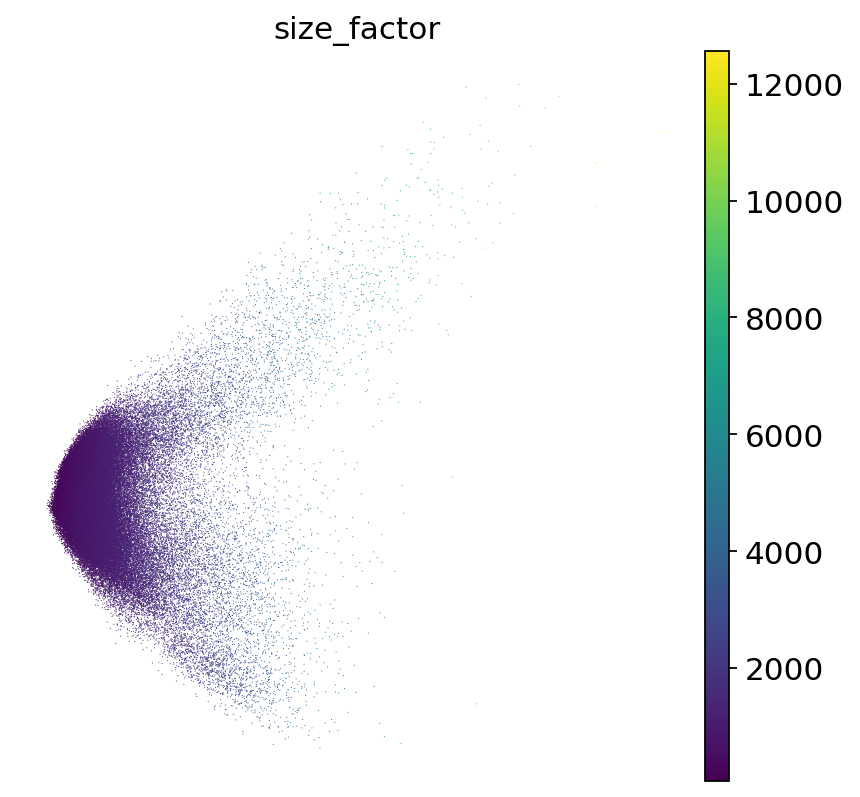

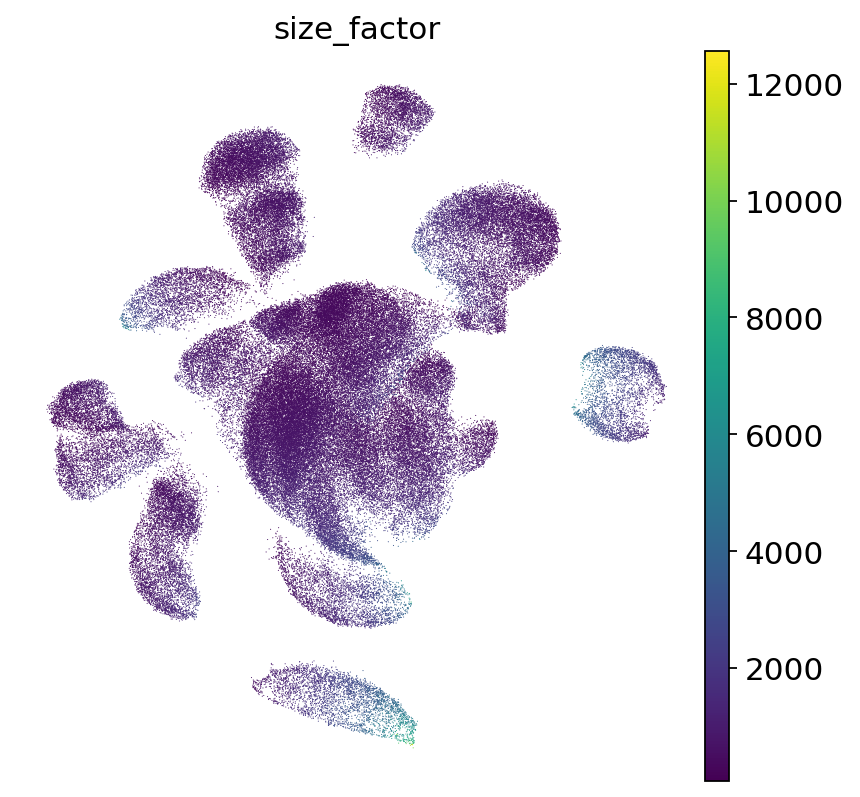

In [43]:
sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated, color="size_factor")

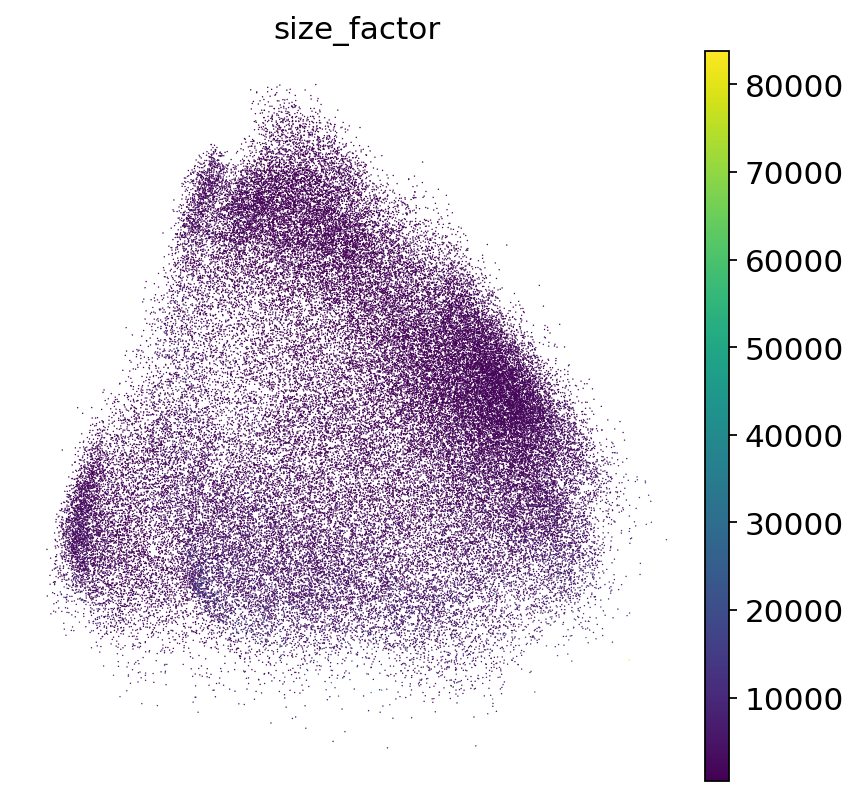

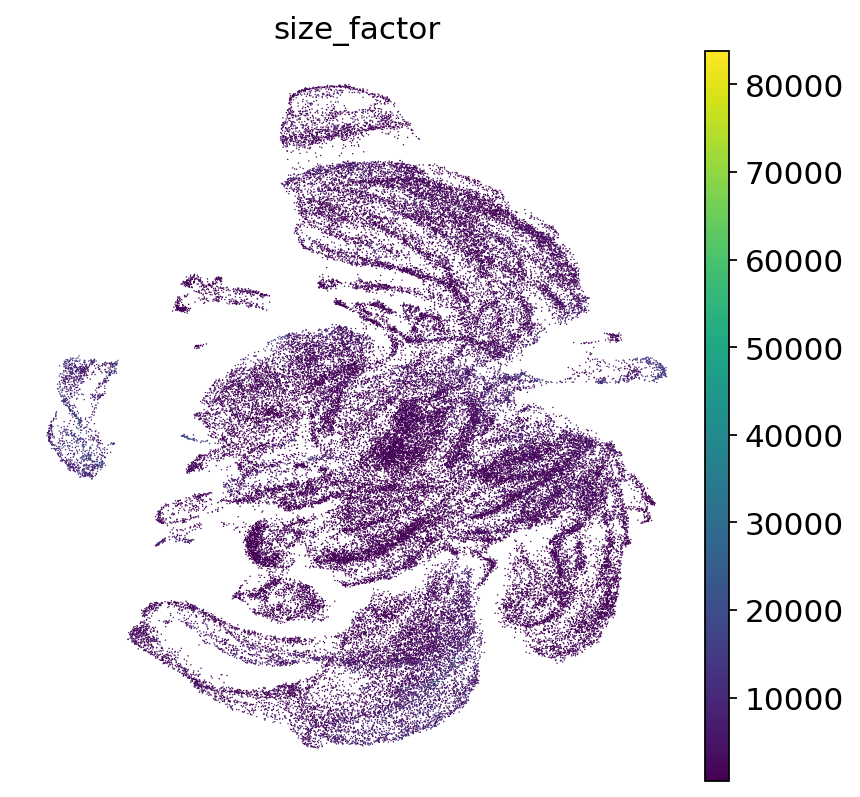

In [44]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

Merge and plot the generated and real data

In [46]:
dataset_type = ["Real" for _ in range(adata_original.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["cell_type"] = list(adata_original.obs.cell_type)+condition_names[:450000]

In [48]:
adata_merged = sc.AnnData(X=torch.cat([torch.tensor(adata_original.X.A), X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [49]:
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


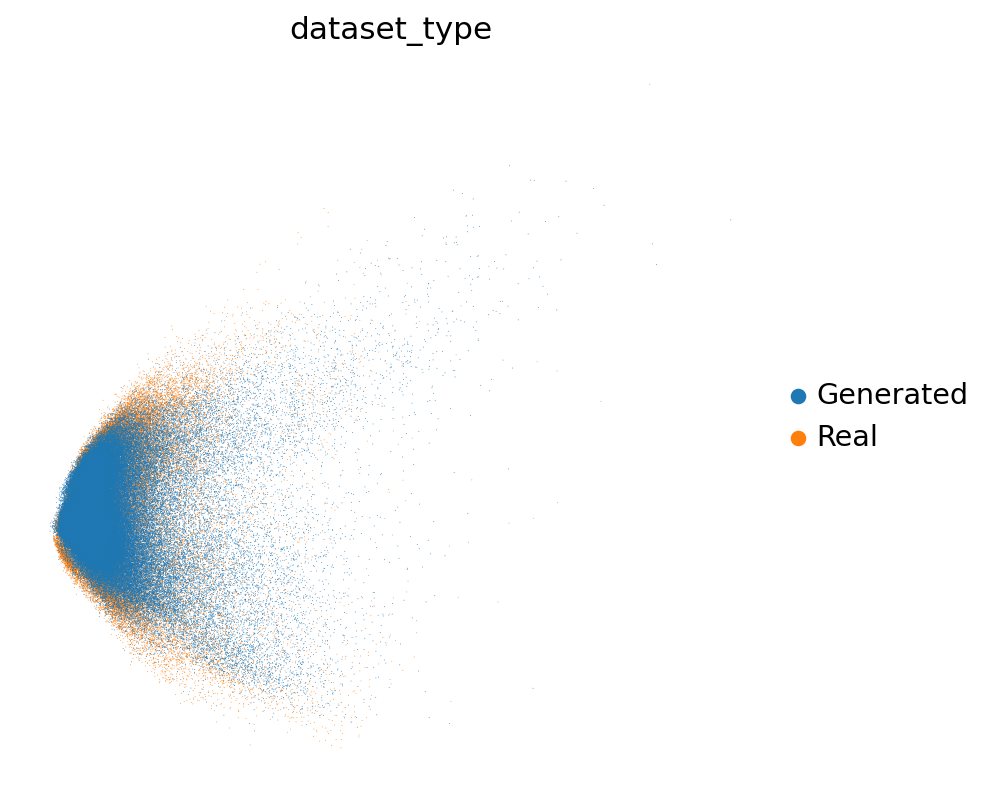

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

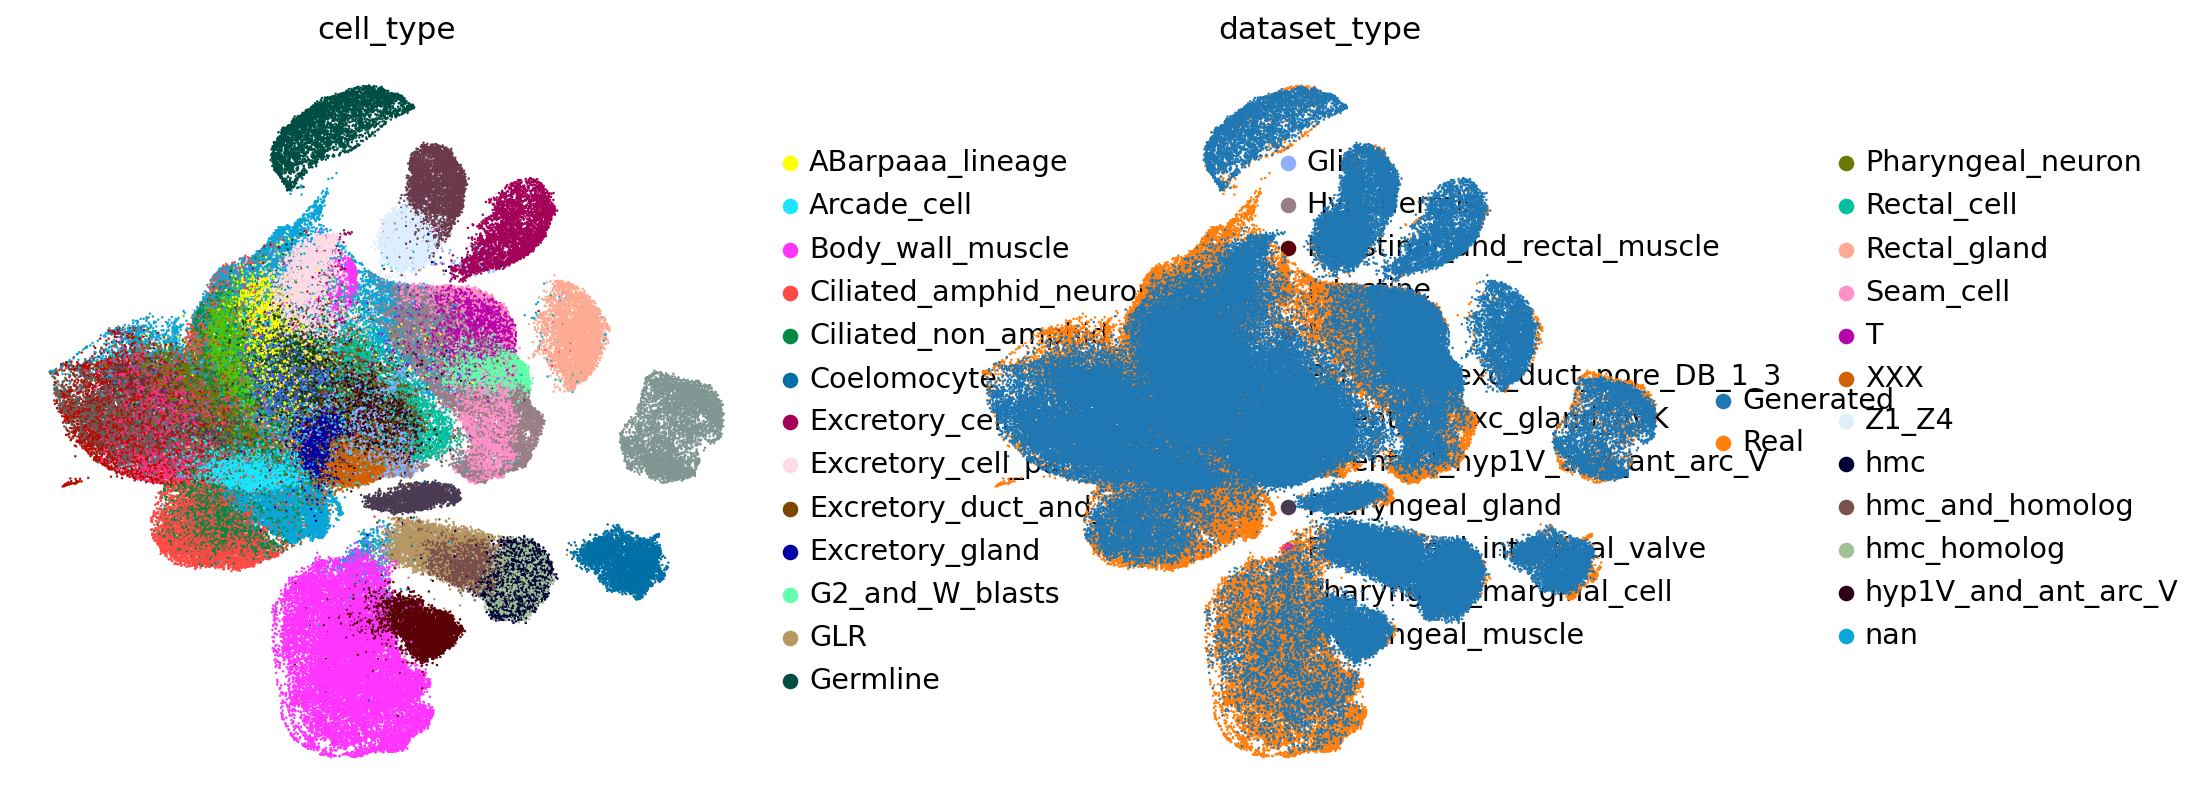

In [50]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["cell_type","dataset_type"], s=5)
# sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color=["classes"])

In [51]:
unique_cell_types_augmented = np.unique(adata_merged.obs.cell_type, return_counts=True)

In [52]:
dict(zip(unique_cell_types_augmented[0], unique_cell_types_augmented[1]))

{'ABarpaaa_lineage': 3680,
 'Arcade_cell': 3856,
 'Body_wall_muscle': 17457,
 'Ciliated_amphid_neuron': 8293,
 'Ciliated_non_amphid_neuron': 6913,
 'Coelomocyte': 4066,
 'Excretory_cell': 3714,
 'Excretory_cell_parent': 3788,
 'Excretory_duct_and_pore': 3703,
 'Excretory_gland': 3617,
 'G2_and_W_blasts': 3712,
 'GLR': 4086,
 'Germline': 3971,
 'Glia': 4861,
 'Hypodermis': 9462,
 'Intestinal_and_rectal_muscle': 3942,
 'Intestine': 4810,
 'M_cell': 3685,
 'Parent_of_exc_duct_pore_DB_1_3': 3778,
 'Parent_of_exc_gland_AVK': 3713,
 'Parent_of_hyp1V_and_ant_arc_V': 3782,
 'Pharyngeal_gland': 4003,
 'Pharyngeal_intestinal_valve': 3889,
 'Pharyngeal_marginal_cell': 4141,
 'Pharyngeal_muscle': 5552,
 'Pharyngeal_neuron': 4609,
 'Rectal_cell': 3737,
 'Rectal_gland': 3656,
 'Seam_cell': 5600,
 'T': 3664,
 'XXX': 4177,
 'Z1_Z4': 3784,
 'hmc': 3773,
 'hmc_and_homolog': 3625,
 'hmc_homolog': 3646,
 'hyp1V_and_ant_arc_V': 3616,
 'nan': 31399}

In [53]:
sc.write("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/integration/neurips/augmented_c_elegans_train.h5ad", adata_merged)